# Exploratory Analysis of Credit Risk dataset

## Goal

Our goal with this analysis is to build a model to help determine whether or not a person will default on their credit loan.

Dataset: https://www.kaggle.com/datasets/laotse/credit-risk-dataset

### Let's start with the imports

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from lightgbm import LGBMClassifier
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import IsolationForest, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.svm import SVC

### Load and View the dataset

Next we load and view the dataset to get a feel of what we're working with...

From this we can see that _loan_status_ is our variable of interest. It is binary with 0 meaning the person's credit loan did not default and 1 meaning that it did.

In [95]:
df = pd.read_csv("credit_risk_dataset.csv")
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


### Distribution of Target Variable: _loan_status_

<Axes: xlabel='loan_status', ylabel='count'>

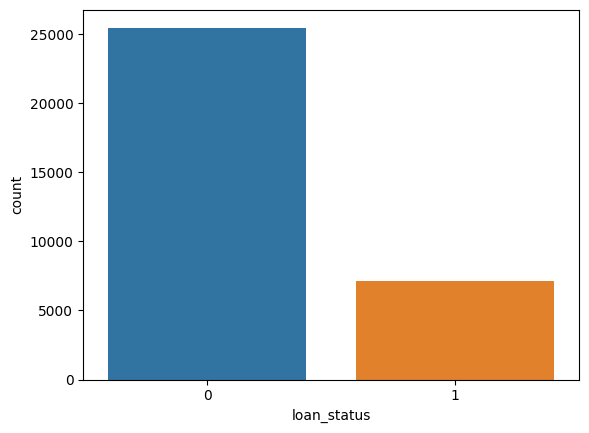

In [96]:
sns.countplot(x=df.loan_status)

### Split the data

In [97]:
train, test = train_test_split(df, random_state=123)

### Categorize Features

We categorize the features into _numeric_features_ (any columns that are numeric) , _categorical_features_ (any columns that can be split into definitive categories) , and _drop_features_ (any features that are irrelevant or the target variable)

In [98]:
numeric_features = ['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_age', 'person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
drop_features = ['loan_status']

### Preprocessing Pipeline

Our data isn't perfect, there missing or N/A data so we should clean it up a bit. 

_numeric_features_ data is replaced with the most frequent occurance in that column <br>
_categorical_features_ data is replaced with _?_ as each categorical feature column has unique data

Once the data has been imputed and encoded, the pipeline returns _y_train_, _y_test_, the preprocessor, and the encoded X train and test (_X_train_enc_ and _X_test_enc_)

In [99]:
def preprocess_features(train, test, numeric_features, categorical_features, drop_features):
    
    all_features = set(numeric_features + categorical_features + drop_features)
    
    if set(train.columns) != all_features:
        print("Missing columns", set(df_train.columns) - all_features)
        print("Extra columns", all_features - set(df_train.columns))
        raise Exception("Columns do not match")
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler())
    ])  
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])
    
    preprocessor.fit(train)
    
    one_hot_encoding = preprocessor.named_transformers_['categorical'].named_steps['onehot']
    ohe_feature_names = list(one_hot_encoding.get_feature_names_out(categorical_features))
    new_columns = numeric_features + ohe_feature_names
    
    X_train_enc = pd.DataFrame(preprocessor.transform(train).toarray(), index=train.index, columns=new_columns)
    X_test_enc  = pd.DataFrame(preprocessor.transform(test).toarray(),  index=test.index,  columns=new_columns)
    
    y_train = train["loan_status"]
    y_test  = test["loan_status"]
    
    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [100]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(train, test, numeric_features, categorical_features, drop_features)

### Outlier Detection: Isolation Forest

The IsolationForest only detected 44 outliers on a dataset of 32581 rows × 12 columns. This means that although there are some outliers, there is not a large enough propoertion to skew future results

In [101]:
isolation = IsolationForest(random_state=123)
predicted_outliers_if = isolation.fit_predict(X_train_enc)
predicted_outliers_if = predicted_outliers_if < 0
n_outliers_if = sum(predicted_outliers_if)
print("IsolationForest detected", n_outliers_if, "outliers.")

IsolationForest detected 44 outliers.


### Outlier Detection DBSCAN

To validate the results of IsolationForest, we opt to use DBSCAN as well. DBSCAN however, is a bit more complicated, the steps to find outliers is as follows:

1. Compute the pairwise distances between all data points

In [102]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_train_enc)
distances, indices = nbrs.kneighbors(X_train_enc)

2. Sort the distances and plot them to find an elbow point

Text(0.5, 1.0, 'Elbow Plot from KNN')

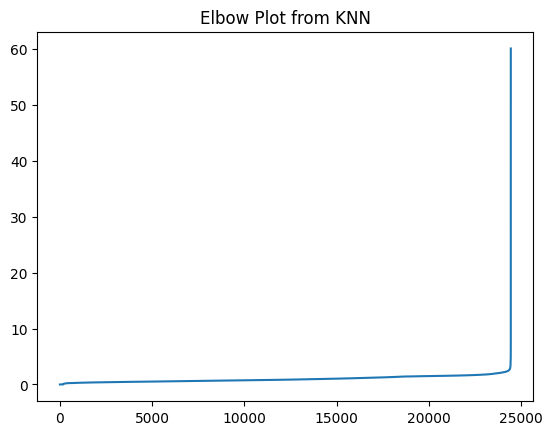

In [103]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title("Elbow Plot from KNN")

3. Find the optimal _eps_ hyperparameter for DBSCAN from the elbow plot

In [104]:
ddist = np.gradient(np.gradient(distances))
eps_idx = np.argmax(ddist)
eps = distances[eps_idx]

4. Perform DBSCAN and find the outliers

In [105]:
dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan.fit(X_train_enc)
predicted_outliers_dbscan = dbscan.labels_ == -1
n_outliers_dbscan = sum(predicted_outliers_dbscan)
print("DBSCAN detected", n_outliers_dbscan, "outliers.")

DBSCAN detected 0 outliers.


From this we see that although IsolationForest found 44 outliers, DBSCAN found 0. This is because each performs outlier detection in a different way. IsolationForest is effective at detecting isolated anomalies regardless of the data's underlying distribution. Whereas, DBSCAN is a density-based clustering algorithm that can identify clusters and detect outliers as noise points. It's suitable when outliers are characterized by their low density compared to the surrounding data. Luckily for us in this analysis, the number of outliers will likely have very little effect on the end results thus we do not need to decide between the two detection methods.

### Scoring: Dummy Classifier

In [107]:
dc = DummyClassifier(strategy='stratified', random_state=123)
dc.fit(train, y_train)
dc_trscore = dc.score(train, y_train)
dc_tescore = dc.score(test, y_test)

### Scoring: Logistic Regression

In [108]:
lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=2000, random_state=123))
lr_pipe.fit(train, y_train)
lr_trscore = lr_pipe.score(train, y_train)
lr_tescore = lr_pipe.score(test, y_test)

### Scoring: LGBM Classifier

In [109]:
lgbm_pipe = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
lgbm_pipe.fit(train, y_train)
lgbm_trscore = lgbm_pipe.score(train, y_train)
lgbm_tescore = lgbm_pipe.score(test, y_test)

### Scoring: AdaBoost Classifier

In [110]:
ada_pipe = make_pipeline(preprocessor, AdaBoostClassifier(random_state=123))
ada_pipe.fit(train, y_train)
ada_trscore = ada_pipe.score(train, y_train)
ada_tescore = ada_pipe.score(test, y_test)

### Scoring: Random Forest Classifier

In [111]:
rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
rf_pipe.fit(train, y_train)
rf_trscore = rf_pipe.score(train, y_train)
rf_tescore = rf_pipe.score(test, y_test)

### Scoring: Gradient Boosting Classifier

In [112]:
gb_pipe = make_pipeline(preprocessor, GradientBoostingClassifier(random_state=123))
gb_pipe.fit(train, y_train)
gb_trscore = gb_pipe.score(train, y_train)
gb_tescore = gb_pipe.score(test, y_test)

### Scoring: SVC

In [113]:
svc_pipe = make_pipeline(preprocessor, SVC(random_state=123))
svc_pipe.fit(train, y_train)
svc_trscore = svc_pipe.score(train, y_train)
svc_tescore = svc_pipe.score(test, y_test)

### Scoring: KNN Classifier

In [114]:
knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())
knn_pipe.fit(train, y_train)
knn_trscore = knn_pipe.score(train, y_train)
knn_tescore = knn_pipe.score(test, y_test)

### Scoring Summary

We find that LGBM Classifier had the highest test score and Dummy Classifier had the lowest. A higher test score indicates how much better the model has generalized the data. Meaning that LGBM did the best at generalizing our credit risk data. Since there is no significant difference between the training score and test score, it is likely that none of the models overfit the data. We will still perform cross-validation and hyperparameter tuning as it may change which classifier we should consider using in deployment.

In [115]:
score_summary = pd.DataFrame([dc_trscore, lr_trscore, lgbm_trscore, ada_trscore,
                              rf_trscore, gb_trscore, svc_trscore, knn_trscore],
                             index=["Dummy Classifier", "Logistic Regression", "LightGBM Classifier", 
                                    "AdaBoost Classifier", "Random Forest", "Gradient Boosting", "SVM", "KNN"])
score_summary['Test Score'] = [dc_tescore, lr_tescore, lgbm_tescore, ada_tescore, rf_tescore, gb_tescore, svc_tescore, knn_tescore]
score_summary.columns = ['Train Score', 'Test Score']
score_summary = score_summary.sort_values(by=['Test Score'], ascending=False)
score_summary

,Train Score,Test Score
LightGBM Classifier,0.943278,0.934569
Random Forest,0.999959,0.932114
Gradient Boosting,0.928709,0.925117
SVM,0.922161,0.916155
KNN,0.911725,0.887798
AdaBoost Classifier,0.885451,0.882519
Logistic Regression,0.864743,0.870489
Dummy Classifier,0.661592,0.661061


### Cross-validation

In [116]:
dc_results = pd.DataFrame(cross_validate(dc, train, y_train, return_train_score=True)).mean()

lr_results = pd.DataFrame(cross_validate(lr_pipe, train, y_train, return_train_score=True)).mean()

lgbm_results = pd.DataFrame(cross_validate(lgbm_pipe, train, y_train, return_train_score=True)).mean()

ada_results = pd.DataFrame(cross_validate(ada_pipe, train, y_train, return_train_score=True)).mean()

rf_results = pd.DataFrame(cross_validate(rf_pipe, train, y_train, return_train_score=True)).mean()

gb_results = pd.DataFrame(cross_validate(gb_pipe, train, y_train, return_train_score=True)).mean()

svc_results = pd.DataFrame(cross_validate(svc_pipe, train, y_train, return_train_score=True)).mean()

knn_results = pd.DataFrame(cross_validate(knn_pipe, train, y_train, return_train_score=True)).mean()

### Cross-validation Summary

Although in the previous part we recognized that there is _likely_ no overfitting that occurs, we see that LGBM is still the model with the highest test score indicating that there wasn't any overfitting.

In [117]:
cv_summary = pd.DataFrame([dc_results, lr_results, lgbm_results, ada_results,
                           rf_results, gb_results, svc_results, knn_results],
                          index=["Dummy Classifier", "Logistic Regression", "LightGBM Classifier", 
                                 "AdaBoost Classifier", "Random Forest", "Gradient Boosting", "SVM", "KNN"])
cv_summary = cv_summary.sort_values(by=["test_score"], ascending=False)
cv_summary

,fit_time,score_time,test_score,train_score
LightGBM Classifier,0.218327,0.019200,0.934807,0.945815
Random Forest,9.150616,0.089008,0.932638,0.999990
Gradient Boosting,2.687978,0.018804,0.925107,0.928105
SVM,6.933975,0.938010,0.912707,0.921567
AdaBoost Classifier,0.940524,0.037807,0.884837,0.885922
KNN,0.055085,1.570017,0.878903,0.909372
Logistic Regression,0.298141,0.011200,0.864047,0.864723
Dummy Classifier,0.002399,0.000999,0.658686,0.659188


### Hyperparameter Tuning: Logistic Regression

In [118]:
lr_param_grid = {
    "logisticregression__C": [0.001, 0.01, 1, 10, 100, 1000, 10000],
    "logisticregression__class_weight": [None, 'balanced'],
    "logisticregression__max_iter": [500, 1000, 2000],
}

grid_search_lr = GridSearchCV(lr_pipe, lr_param_grid, verbose=2, n_jobs=-1, cv=5, scoring='accuracy')
grid_search_lr.fit(train, y_train)

lr_trscore = grid_search_lr.score(train, y_train)
lr_tescore = grid_search_lr.score(test, y_test)

print(f"Best parameters: {grid_search_lr.best_params_}")
print(f"Test score: {grid_search_lr.best_score_:.3f}")

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters: {'logisticregression__C': 1, 'logisticregression__class_weight': None, 'logisticregression__max_iter': 500}
Test score: 0.864


### Hyperparameter Tuning: LGBM Classifier

In [119]:
param_grid = {
    "lgbmclassifier__learning_rate": [0.05, 0.1, 0.2],
    "lgbmclassifier__n_estimators": [50, 100, 200],
    "lgbmclassifier__max_depth": [3, 5, 7],
    "lgbmclassifier__reg_alpha": [0, 0.1, 0.5],
    "lgbmclassifier__reg_lambda": [0, 0.1, 0.5],
    "lgbmclassifier__min_child_samples": [5, 10, 20]
}

grid_search_lgbm = GridSearchCV(lgbm_pipe, param_grid, verbose=2, n_jobs=-1, cv=5, scoring='accuracy')
grid_search_lgbm.fit(train, y_train)

lgbm_trscore = grid_search_lgbm.score(train, y_train)
lgbm_tescore = grid_search_lgbm.score(test, y_test)

print(f"Best parameters: {grid_search_lgbm.best_params_}")
print(f"Test score: {grid_search_lgbm.best_score_:.3f}")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters: {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 7, 'lgbmclassifier__min_child_samples': 20, 'lgbmclassifier__n_estimators': 200, 'lgbmclassifier__reg_alpha': 0, 'lgbmclassifier__reg_lambda': 0.1}
Test score: 0.936


### Hyperparameter Tuning: AdaBoost Classifier

In [120]:
param_grid_ada = {
    "adaboostclassifier__n_estimators": [50, 100, 200, 500],
    "adaboostclassifier__learning_rate": [0.001, 0.01, 0.1, 1]
}

grid_search_ada = GridSearchCV(ada_pipe, param_grid_ada, verbose=2, n_jobs=-1, cv=5, scoring='accuracy')
grid_search_ada.fit(train, y_train)

ada_trscore = grid_search_ada.score(train, y_train)
ada_tescore = grid_search_ada.score(test, y_test)

print(f"Best parameters: {grid_search_ada.best_params_}")
print(f"Test score: {grid_search_ada.best_score_:.3f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 500}
Test score: 0.888


### Hyperparameter Tuning: Random Forest Classifier

In [121]:
param_grid = {
    "randomforestclassifier__n_estimators": [50, 100, 200],
    "randomforestclassifier__max_depth": [3, 5, 7],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
    "randomforestclassifier__max_features": ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(rf_pipe, param_grid, verbose=2, n_jobs=-1, cv=5, scoring='accuracy')
grid_search_rf.fit(train, y_train)

rf_trscore = grid_search_rf.score(train, y_train)
rf_tescore = grid_search_rf.score(test, y_test)

print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Test score: {grid_search_rf.best_score_:.3f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'randomforestclassifier__max_depth': 7, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 200}
Test score: 0.910


### Hyperparameter Tuning: Gradient Boosting Classifier

In [122]:
param_grid = {
    "gradientboostingclassifier__n_estimators": [50, 100, 200],
    "gradientboostingclassifier__max_depth": [3, 5, 7],
    "gradientboostingclassifier__min_samples_split": [2, 5, 10],
    "gradientboostingclassifier__min_samples_leaf": [1, 2, 4],
    "gradientboostingclassifier__max_features": ['sqrt', 'log2']
}

grid_search_gb = GridSearchCV(gb_pipe, param_grid, verbose=2, n_jobs=-1, cv=5, scoring='accuracy')
grid_search_gb.fit(train, y_train)

gb_trscore = grid_search_gb.score(train, y_train)
gb_tescore = grid_search_gb.score(test, y_test)

print(f"Best parameters: {grid_search_gb.best_params_}")
print(f"Test score: {grid_search_gb.best_score_:.3f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__min_samples_leaf': 2, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 200}
Test score: 0.934


### Hyperparameter Tuning: SVC

In [123]:
param_grid_svc = {
    "svc__C": [0.1, 1, 10, 100],
#     "svc__kernel": ["linear", "rbf", "poly"], TOO SLOW
#     "svc__gamma": ["scale", "auto"], TOO SLOW
}

grid_search_svc = GridSearchCV(svc_pipe, param_grid_svc, verbose=2, n_jobs=-1, cv=5, scoring='accuracy')
grid_search_svc.fit(train, y_train)

svc_trscore = grid_search_svc.score(train, y_train)
svc_tescore = grid_search_svc.score(test, y_test)

print(f"Best parameters: {grid_search_svc.best_params_}")
print(f"Test score: {grid_search_svc.best_score_:.3f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'svc__C': 10}
Test score: 0.917


### Hyperparameter Tuning: KNN Classifier

In [124]:
param_grid_knn = {
    "kneighborsclassifier__n_neighbors": [3, 5, 7, 9],
    "kneighborsclassifier__weights": ["uniform", "distance"],
}

grid_search_knn = GridSearchCV(knn_pipe, param_grid_knn, verbose=2, n_jobs=-1, cv=5, scoring='accuracy')
grid_search_knn.fit(train, y_train)

knn_trscore = grid_search_knn.score(train, y_train)
knn_tescore = grid_search_knn.score(test, y_test)

print(f"Best parameters: {grid_search_knn.best_params_}")
print(f"Test score: {grid_search_knn.best_score_:.3f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__weights': 'distance'}
Test score: 0.886


### Hyperparameter Tuning Summary

In [125]:
tunedscore_summary = pd.DataFrame([dc_trscore, lr_trscore, lgbm_trscore, ada_trscore,
                              rf_trscore, gb_trscore, svc_trscore, knn_trscore],
                             index=["Dummy Classifier", "Logistic Regression", "LightGBM Classifier", 
                                    "AdaBoost Classifier", "Random Forest", "Gradient Boosting", "SVM", "KNN"])
tunedscore_summary['Test Score tuned'] = [dc_tescore, lr_tescore, lgbm_tescore, ada_tescore, rf_tescore, gb_tescore, svc_tescore, knn_tescore]
tunedscore_summary.columns = ['Train Score tuned', 'Test Score tuned']
tunedscore_summary = tunedscore_summary.sort_values(by=['Test Score tuned'], ascending=False)
tunedscore_summary

,Train Score tuned,Test Score tuned
LightGBM Classifier,0.951586,0.935797
Gradient Boosting,0.952118,0.934692
SVM,0.939636,0.918610
Random Forest,0.914344,0.912595
KNN,1.000000,0.891849
AdaBoost Classifier,0.892695,0.890376
Logistic Regression,0.864743,0.870489
Dummy Classifier,0.661592,0.661061


### Hyperparameter Tuned vs Untuned Summary

We see that even after tuning the hyperparameters of all the classifiers, LGBM Classifier still boasted the highest test score with a very close second by Gradient Boosting Classifier. As such, we will use LGBM Classifier as our primary classifier moving forward in our analysis.

In [126]:
final_summary = pd.concat([tunedscore_summary,cv_summary], axis=1).sort_values(by="Test Score tuned", ascending=False)
final_summary = final_summary.drop(columns=['fit_time', 'score_time'])
final_summary

,Train Score tuned,Test Score tuned,test_score,train_score
LightGBM Classifier,0.951586,0.935797,0.934807,0.945815
Gradient Boosting,0.952118,0.934692,0.925107,0.928105
SVM,0.939636,0.918610,0.912707,0.921567
Random Forest,0.914344,0.912595,0.932638,0.999990
KNN,1.000000,0.891849,0.878903,0.909372
AdaBoost Classifier,0.892695,0.890376,0.884837,0.885922
Logistic Regression,0.864743,0.870489,0.864047,0.864723
Dummy Classifier,0.661592,0.661061,0.658686,0.659188


### Confusion Matrix and Classification Report Terminology

Precision: 
Precision is a measure of how many of the predicted positive instances are actually true positives

Recall: 
Recall, also known as sensitivity or true positive rate, measures the proportion of actual positive instances that are correctly identified.

F1-score: 
The F1-score is the harmonic mean of precision and recall. It provides a balanced measure that considers both precision and recall. A high F1-score indicates a good balance between precision and recall.

Support: 
Support refers to the number of instances in each class.

Accuracy:
Accuracy represents the overall correctness of the classification model.

Macro Avg:
The macro average calculates the average of precision, recall, and F1-score across all classes, regardless of their support or imbalance.

Weighted Avg:
The weighted average calculates the average of precision, recall, and F1-score, weighted by the support of each class. It provides a measure that takes into account the class imbalance.

### Confusion Matrix and Classification Report

From the classification report we see the following: 

1. Precision:

93% of the instances predicted as "Loan Not Default" are true positives. <br>
97% of the instances predicted as "Loan Defaults" are true positives.

2. Recall:

99% of the actual "Loan Not Default" instances are correctly classified. <br>
72% of the actual "Loan Defaults" instances are correctly classified.

This difference is likely due to the class imbalances we saw early in our analysis.

3. F1-score:

"Loan Not Default" had an F1-score of 0.96. <br>
"Loan Defaults" had an F1-score of 0.82.

4. Support:

"Loan Not Default" has 6,407 instances. <br>
"Loan Defaults" has 1,739 instances.

5. Accuracy:

93% accuracy indicates that 93% of the instances in the dataset are correctly classified.

6. Macro Avg:

The macro avgs are: precision is 0.95, recall is 0.86, and F1-score is 0.89.

7. Weighted Avg:

The weighted avgs are: precision is 0.94, recall is 0.93, and F1-score is 0.93.

Overall, the classification report suggests that the model performs well in identifying "Loan Not Default" instances, with high precision, recall, and F1-score. However, it is relatively less accurate in identifying "Loan Defaults," as indicated by the lower recall and F1-score for that class.

However, all hope is not lost as having a model that can accurately identify users who will not default on their credit loan is also helpful!

                  precision    recall  f1-score   support

Loan Not Default       0.93      0.99      0.96      6407
   Loan Defaults       0.97      0.72      0.82      1739

        accuracy                           0.93      8146
       macro avg       0.95      0.86      0.89      8146
    weighted avg       0.94      0.93      0.93      8146



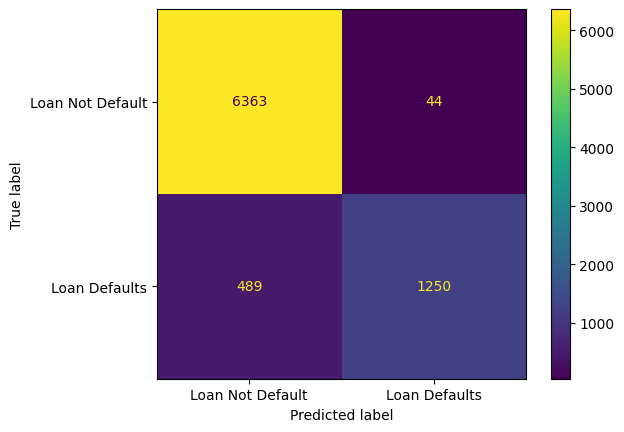

In [127]:
ConfusionMatrixDisplay.from_estimator(lgbm_pipe, test, y_test, display_labels=["Loan Not Default", "Loan Defaults"])
print(classification_report(y_test, lgbm_pipe.predict(test), target_names=("Loan Not Default", "Loan Defaults")))

### ROC Curve & AUC Score

The ROC curve and AUC score we see below indicate the following:

1. Good Predictive Performance: 

An AUC score of 0.94 indicates that the model has a high probability of assigning a higher score or probability to a randomly chosen loan default instance compared to a randomly chosen non-default instance. This suggests that the model is effective at capturing the underlying patterns and risk factors associated with credit defaults.

2. Strong Discrimination: 

A higher AUC score signifies that the model can effectively rank instances and assign higher probabilities to loan defaults relative to non-defaults. The model's ability to differentiate between the two classes is quite robust, making it valuable for risk assessment and decision-making.

3. Potential for Reliable Risk Assessment: 

With a high AUC score, the model can be considered reliable in predicting credit risk. It can aid in identifying potential default cases and help lenders or financial institutions make informed decisions about granting loans or managing existing credit portfolios.

4. Potential for Superior Model Performance: 

AUC scores closer to 1 indicate a stronger model performance, so a score of 0.94 suggests that the model is performing at a high level. While there is always room for improvement, an AUC score of 0.94 indicates that the model is already achieving a significant level of accuracy and discrimination.

AUC Score 0.9413684877622259


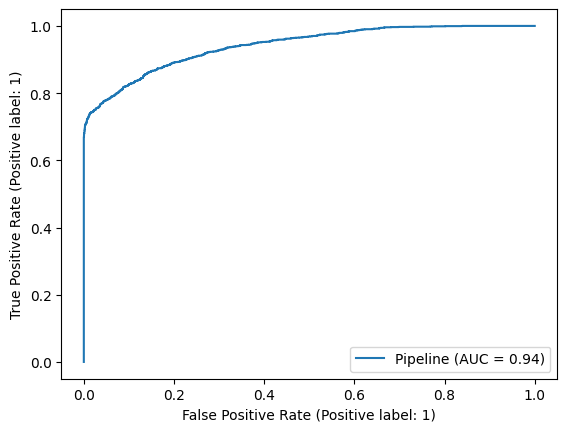

In [128]:
RocCurveDisplay.from_estimator(lgbm_pipe, test, y_test)
print("AUC Score", roc_auc_score(y_test, lgbm_pipe.predict_proba(test)[:,1]))

### Feature Importances

The feature importances reflect the relative importance of each feature in the model's decision-making process.

The following are an analysis on the top 5 important features in predicting the target variable _loan_status_

_person_income_: With an importance value of 739, it appears to be the most important feature in predicting credit risk. A higher income might indicate a lower risk of default, making it a significant factor in assessing creditworthiness.

_loan_int_rate_: This feature has an importance value of 322, suggesting that the interest rate assigned to the loan plays a significant role in determining credit risk. Higher interest rates may indicate higher risk, leading to a greater likelihood of default.

_loan_percent_income_: The importance value of 250 indicates that the loan amount as a percentage of the borrower's income is an influential factor in predicting credit risk. Higher loan-to-income ratios may increase the risk of default.

_loan_amnt_: With an importance value of 239, the loan amount itself is an important predictor of credit risk. Larger loan amounts may indicate higher risk, as borrowers might struggle to repay larger debts.

_person_emp_length_: The employment length of the borrower has an importance value of 197. This suggests that the length of employment plays a role in assessing creditworthiness. Borrowers with longer employment histories might be considered more stable and less likely to default.

In [129]:
lgbm_importances = pd.DataFrame(data=np.transpose(lgbm_pipe[1].feature_importances_), index=X_train_enc.columns, columns=["Importance"])
lgbm_importances.sort_values(by="Importance", ascending=False)

,Importance
person_income,739
loan_int_rate,322
loan_percent_income,250
loan_amnt,239
person_emp_length,197
...,...
person_age_63,0
person_age_64,0
person_age_65,0
person_age_66,0


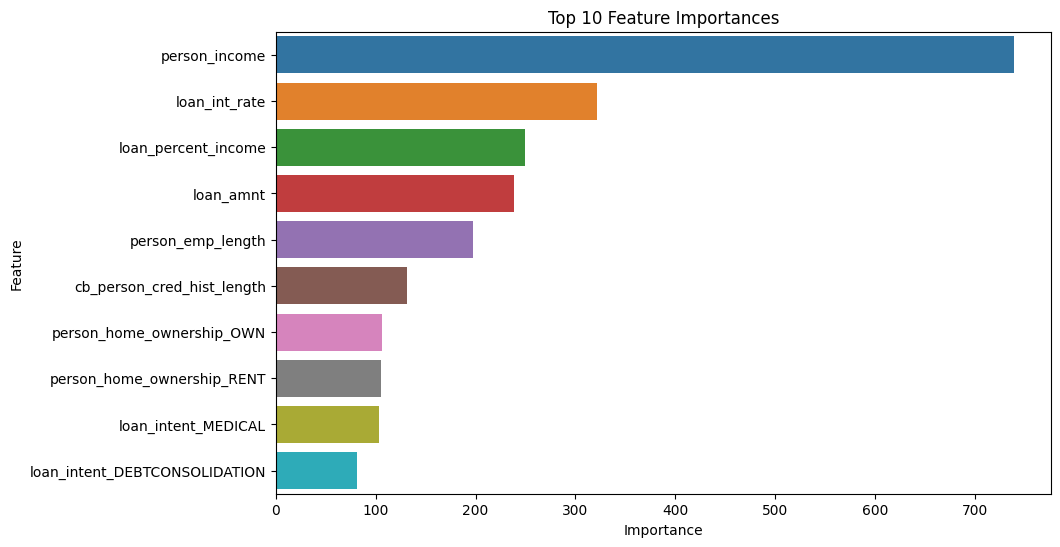

In [130]:
lgbm_importances_sorted = lgbm_importances.sort_values(by="Importance", ascending=False)
top_features = lgbm_importances_sorted.head(10)
plt.figure(figsize=(10, 6))  # Optional: adjust the figure size
sns.barplot(x=top_features["Importance"], y=top_features.index)

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')

plt.show()

### Predictions

Assuming a 50% prediction value as the Loan Defaults, the model identifies 1294 users will default on their loan or about 16% of test set and that 84% will not default on their loan. 

In [131]:
Preds1 = [pred[1] for pred in lgbm_pipe.predict_proba(test)]
Preds0 = [pred[0] for pred in lgbm_pipe.predict_proba(test)]

defaults_1_predictions = pd.DataFrame(data = {'id': test.index, 'Defaults_1%': Preds1})
notdefaults_0_predictions = pd.DataFrame(data = {'id': test.index, 'NotDefaults_0%': Preds0})

predictions = defaults_1_predictions
predictions['NotDefaults_0%'] = notdefaults_0_predictions['NotDefaults_0%']
predictions = predictions.reset_index(drop=True)

predictions['Defaults_1%'] = 100 * predictions['Defaults_1%']
predictions['NotDefaults_0%'] = 100 * predictions['NotDefaults_0%']

predictions.sort_values(by=['Defaults_1%'], ascending=False)
(predictions['Defaults_1%'] >= 50.0).value_counts()

Defaults_1%
False    6852
True     1294
Name: count, dtype: int64

### Risk Segmentation Plot 

The following plot segments users into different risk categories based on the predicted probabilities of loan defaults. 

If predicted probability of loan default is < 30% = Low Risk
If predicted probability of loan default is >= 30% and < 70% = Medium Risk
If predicted probability of loan default is >= 70% = High Risk

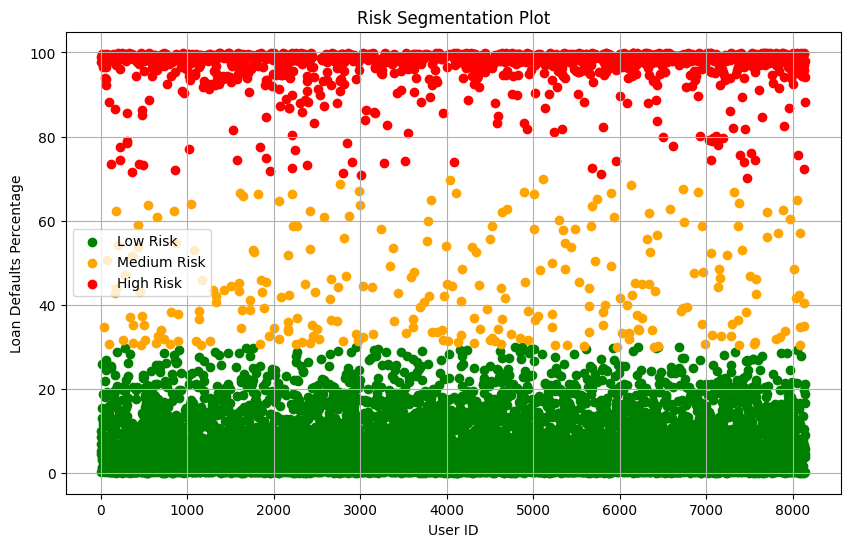

In [132]:
low_risk = predictions[predictions['Defaults_1%'] < 30]
medium_risk = predictions[(predictions['Defaults_1%'] >= 30) & (predictions['Defaults_1%'] < 70)]
high_risk = predictions[predictions['Defaults_1%'] >= 70]

plt.figure(figsize=(10, 6))
plt.scatter(low_risk.index, low_risk['Defaults_1%'], color='green', label='Low Risk')
plt.scatter(medium_risk.index, medium_risk['Defaults_1%'], color='orange', label='Medium Risk')
plt.scatter(high_risk.index, high_risk['Defaults_1%'], color='red', label='High Risk')

plt.xlabel('User ID')
plt.ylabel('Loan Defaults Percentage')
plt.title('Risk Segmentation Plot')

plt.legend()
plt.grid(True)

plt.show()

## Conclusion

In conclusion we see that our model is reliable and accurate at predicting if a user will not default on their loan. Although this may not be the exact goal of this analysis, it is still useful in determining the risk associated with any user taking out a credit loan. 